In [57]:
import os

import certifi

# Set the environment variables within your Python script
os.environ["REQUESTS_CA_BUNDLE"] = certifi.where()
os.environ["SSL_CERT_FILE"] = certifi.where()

print("REQUESTS_CA_BUNDLE:", os.environ.get("REQUESTS_CA_BUNDLE"))
print("SSL_CERT_FILE:", os.environ.get("SSL_CERT_FILE"))

## was gna kill myself over this ERROR BRUH

REQUESTS_CA_BUNDLE: /Users/sarahSTACS/DSA4264-Detoxify/penv/lib/python3.12/site-packages/certifi/cacert.pem
SSL_CERT_FILE: /Users/sarahSTACS/DSA4264-Detoxify/penv/lib/python3.12/site-packages/certifi/cacert.pem


Separate data by year

In [58]:
import pandas as pd

data_path2 = "/Users/sarahSTACS/Downloads/final_data.csv"
df = pd.read_csv(data_path2)
print(df.columns)
# filtered_df = df[["text", "gold_label"]][df["year"] == 2023]
# filtered_df.shape[0]

Index(['text', 'timestamp', 'username', 'link', 'link_id', 'parent_id', 'id',
       'subreddit_id', 'moderation', 'year', 'word_count', 'Sensitive Group',
       'Classification'],
      dtype='object')


get count of each unique value of classification 

In [59]:
classification_counts = df["Classification"].value_counts()
print(classification_counts)

Classification
No Hate/Toxic    355079
Hate 1            22641
Toxic 1           15097
Toxic 2            5563
Hate 2              967
Toxic 3             432
Hate 3              221
Name: count, dtype: int64


clean data which might not be needed anymore

In [60]:
filtered_df = df[df["Classification"] != "No Hate/Toxic"]
text = filtered_df["text"].tolist()
len(text)

44921

In [61]:
import re

# cleaning of Singlish text

# Custom dictionary for translating Singlish terms to standard English
singlish_dict = {
    "lah": "",
    "lor": "",
    "sia": "",
    "leh": "",
    "fuck": "",
    "shit": "",
    "fucker": "",
    "bitch": "",
    "fuk": "",
    "cunt" "fucking": "",
    "sian": "bored",
    "lepak": "relax",
    "shiok": "great",
    "kiasu": "fear of missing out",
    "fomo": "fear of missing out",
    "kopi": "coffee",
    "yaya papaya": "arrogant person",
    "cheem": "complex",
    "aiyo": "oh no",
    "dabao": "takeaway",
    "paiseh": "embarrassed",
    "koped": "stolen",
    "gahmen": "government",
    "gahment": "government",
    "liao": "already",
    "siao": "crazy",
}

# Get the default NLTK English stop words
nltk_stop_words = stopwords.words("english")
custom_stop_words = ["hes", "shes"]  # Add any additional custom stop words

# Combine NLTK stop words with custom stop words
combined_stop_words = set(nltk_stop_words + custom_stop_words)


def clean_singlish(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove extra spaces and special characters
    text = re.sub(r"[^\w\s]", "", text)

    # Tokenize the sentence into words
    words = text.split()

    # Translate Singlish words to Standard English
    cleaned_words = [singlish_dict.get(word, word) for word in words]

    # Remove stop words
    cleaned_words = [word for word in cleaned_words if word not in combined_stop_words]

    # Join the words back into a cleaned sentence
    cleaned_text = " ".join(cleaned_words)

    # Remove any leftover empty phrases
    cleaned_text = re.sub(r"\s+", " ", cleaned_text).strip()

    return cleaned_text


filtered_df["clean_text"] = filtered_df["text"].apply(clean_singlish)
print(filtered_df[["text", "clean_text"]].head())
filtered_df.shape
filtered_df.head()
text = filtered_df["clean_text"].tolist()

                                                 text  \
15                                Tell The F Mon G3rs   
29  Don't ask so many questions, if not PAP arrest...   
45  It's a claim that is well supported by various...   
50  Why come all the way here and complain dipshit...   
74  I can understand giving exemptions for people ...   

                                           clean_text  
15                                    tell f mon g3rs  
29  dont ask many questions pap arrest seditious s...  
45  claim well supported various studies blm hand ...  
50  come way complain dipshit pajeet ape enjoy lif...  
74  understand giving exemptions people cannot vac...  


In [50]:
import nltk
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from nltk.corpus import stopwords
from scipy.cluster import hierarchy as sch
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

# nltk.download('stopwords')
# nltk_stop_words = stopwords.words("english")
# custom_stop_words = nltk_stop_words
# Load the Sentence Transformer model


sentence_model = SentenceTransformer(
    "sentence-transformers/distiluse-base-multilingual-cased-v1"
)
# Create a custom CountVectorizer

representation_model = KeyBERTInspired()

topic_model_1 = BERTopic(
    representation_model=representation_model, embedding_model=sentence_model
)
topics, probs = topic_model_1.fit_transform(text)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [63]:
from bertopic import BERTopic  # Import BERTopic if you're using it
from hdbscan import HDBSCAN  # Ensure HDBSCAN is correctly imported
from transformers import AutoModelForMaskedLM, AutoTokenizer
from umap import UMAP  # Make sure the UMAP package is installed and imported

sentence_model = SentenceTransformer(
    "distiluse-base-multilingual-cased-v1"
)  # embedding
umap_model = UMAP(
    n_neighbors=30,
    n_components=3,
    min_dist=0.11,
    metric="cosine",
    random_state=42,  ##can experiment with bigger clusters
)
hdbscan_model = HDBSCAN(
    min_cluster_size=25,  # Keep this consistent
    min_samples=1,  # Can also be set consistently
    metric="euclidean",  # Use a consistent distance metric
    cluster_selection_method="eom",
    prediction_data=True,
)
representation_model = KeyBERTInspired()
# train the bertopic model
topic_model_custom = BERTopic(
    embedding_model=sentence_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    representation_model=representation_model,
    # nr_topics=50 ## can remove to experiment first
)

topics, probs = topic_model_custom.fit_transform(text)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

code i sent to yijing

In [ ]:
from bertopic import BERTopic  # Import BERTopic if you're using it
from hdbscan import HDBSCAN  # Ensure HDBSCAN is correctly imported
from transformers import AutoModelForMaskedLM, AutoTokenizer
from umap import UMAP  # Make sure the UMAP package is installed and imported

sentence_model = SentenceTransformer(
    "distiluse-base-multilingual-cased-v1"
)  # embedding
umap_model = UMAP(
    n_neighbors=30,
    n_components=3,
    min_dist=0.11,
    metric="cosine",
    random_state=42,  ##can experiment with bigger clusters
)
hdbscan_model = HDBSCAN(
    min_cluster_size=25,  # Keep this consistent
    min_samples=1,  # Can also be set consistently
    metric="euclidean",  # Use a consistent distance metric
    cluster_selection_method="eom",
    prediction_data=True,
)
representation_model = KeyBERTInspired()
# train the bertopic model
topic_model_custom = BERTopic(
    embedding_model=sentence_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    representation_model=representation_model,
    # nr_topics=50 ## can remove to experiment first
)

topics, probs = topic_model_custom.fit_transform(text)
from scipy.cluster import hierarchy as sch

#  Hierarchical topics
linkage_function = lambda x: sch.linkage(
    x, "complete", optimal_ordering=True
)  # use either complete or ward
hierarchical_topics_1 = topic_model_1.hierarchical_topics(
    text, linkage_function=linkage_function
)
topic_model_custom.visualize_hierarchy(hierarchical_topics=hierarchical_topics_1)
topic_keywords = {}
for topic_num in sorted(topic_model_custom.get_topics()):
    try:
        words, scores = zip(*topic_model_custom.get_topic(topic_num))
        topic_keywords[topic_num] = ", ".join(words)
        print(f"Topic {topic_num}: {', '.join(words)}")
    except ValueError:
        print(f"No words found for Topic {topic_num}, skipping...")
        topic_keywords[topic_num] = "No relevant words"  # Handling topics without words

filtered_df["custom_topic"] = topics
filtered_df["Topic_Words"] = filtered_df["custom_topic"].map(topic_keywords)
filtered_df.head()
## input topics to merge here
topics_to_merge = [7, 18]
topic_model_custom.merge_topics(text, topics_to_merge)

# check topics after merging
topic_keywords = {}
for topic_num in sorted(topic_model_custom.get_topics()):
    try:
        words, scores = zip(*topic_model_custom.get_topic(topic_num))
        topic_keywords[topic_num] = ", ".join(words)
        print(f"Topic {topic_num}: {', '.join(words)}")
    except ValueError:
        print(f"No words found for Topic {topic_num}, skipping...")
        topic_keywords[topic_num] = "No relevant words"  # Handling topics without words

did it during the trainiing alr

In [ ]:
ltk_stop_words = stopwords.words("english")


# Combine NLTK stop words with custom Singlish stop words
custom_stop_words = nltk_stop_words
vectorizer_model = CountVectorizer(
    ngram_range=(1, 3), stop_words=custom_stop_words, min_df=3
)  # only accept words with a minimum frequency, change to no. preferred
topic_model_custom.update_topics(texts, vectorizer_model=vectorizer_model)

In [64]:
from scipy.cluster import hierarchy as sch

#  Hierarchical topics
linkage_function = lambda x: sch.linkage(
    x, "complete", optimal_ordering=True
)  # use either complete or ward
hierarchical_topics_1 = topic_model_1.hierarchical_topics(
    text, linkage_function=linkage_function
)
topic_model_custom.visualize_hierarchy(hierarchical_topics=hierarchical_topics_1)

100%|██████████| 360/360 [01:22<00:00,  4.38it/s]


# TOPIC MODEL CUSTOM

In [75]:
topic_keywords = {}
for topic_num in sorted(topic_model_custom.get_topics()):
    try:
        words, scores = zip(*topic_model_custom.get_topic(topic_num))
        topic_keywords[topic_num] = ", ".join(words)
        print(f"Topic {topic_num}: {', '.join(words)}")
    except ValueError:
        print(f"No words found for Topic {topic_num}, skipping...")
        topic_keywords[topic_num] = "No relevant words"  # Handling topics without words

Topic -1: singaporean, singapore, race, countries, cant, country, cannot, better, lol, kids
Topic 0: chinese, china, chinas, nonchinese, mandarin, taiwanese, taiwan, chinatown, singaporean, singaporeans
Topic 1: muslims, christians, muslim, islamic, christianity, islam, christian, evangelicals, atheists, evangelical
Topic 2: singaporeans, singaporean, singapores, singapore, foreigners, foreigner, countries, foreign, migrant, country
Topic 3: foreigners, foreigner, immigrants, foreign, immigrant, overseas, migrants, immigration, deported, migrant
Topic 4: feminism, sexism, feminists, feminist, sexist, misogynistic, genders, patriarchy, masculinity, gender
Topic 5: racist, racists, racism, racial, racially, interracial, discriminate, race, races, discrimination
Topic 6: gay, gays, homosexuals, homosexual, homos, homophobe, homophobic, homosexuality, homophobia, homophobes
Topic 7: boomers, boomer, millennials, millenials, millennial, millenial, generations, generation, youngsters, uncles

In [82]:
## input topics to merge here
topics_to_merge = [7, 18]
topic_model_custom.merge_topics(text, topics_to_merge)

In [84]:
# check topics after merging
topic_keywords = {}
for topic_num in sorted(topic_model_custom.get_topics()):
    try:
        words, scores = zip(*topic_model_custom.get_topic(topic_num))
        topic_keywords[topic_num] = ", ".join(words)
        print(f"Topic {topic_num}: {', '.join(words)}")
    except ValueError:
        print(f"No words found for Topic {topic_num}, skipping...")
        topic_keywords[topic_num] = "No relevant words"  # Handling topics without words

Topic -1: singaporean, singapore, race, countries, cant, country, cannot, better, lol, kids
Topic 0: chinese, china, chinas, nonchinese, mandarin, taiwanese, taiwan, chinatown, singaporean, singaporeans
Topic 1: muslims, christians, muslim, islamic, christianity, islam, christian, evangelicals, atheists, evangelical
Topic 2: singaporeans, singaporean, singapores, singapore, foreigners, foreigner, countries, foreign, migrant, country
Topic 3: foreigners, foreigner, immigrants, foreign, immigrant, overseas, migrants, immigration, deported, migrant
Topic 4: boomers, boomer, millennials, millenials, millennial, generations, generation, seniors, elders, elderly
Topic 5: feminism, sexism, feminists, feminist, equality, sexist, misogynistic, patriarchy, patriarchal, genderneutral
Topic 6: racist, racism, racists, racial, racially, interracial, discriminate, discrimination, race, races
Topic 7: gays, homosexuals, gay, homosexuality, homophobes, homos, homophobe, homophobia, homosexual, homopho

In [66]:
filtered_df["custom_topic"] = topics
topic_classification_counts_custom = (
    filtered_df.groupby(["custom_topic", "Classification"]).size().unstack(fill_value=0)
)
topic_classification_counts_custom["custom_Total"] = (
    topic_classification_counts_custom.sum(axis=1)
)

# Print the resulting DataFrame
print(topic_classification_counts_custom)
topic_classification_counts_custom.to_csv(
    "Topic_Classification_Counts_custom.csv", index=True
)
tc_df_custom = pd.DataFrame(topic_classification_counts_custom)
tc_df_custom["Combined Hate & Toxic 3"] = tc_df_custom["Hate 3"] + tc_df["Toxic 3"]
sorted_df_custom = tc_df_custom.sort_values(
    by="Combined Hate & Toxic 3", ascending=False
)

# Find the top 3 values (this includes handling ties)
top_values = sorted_df_custom["Combined Hate & Toxic 3"].nlargest(3)
min_top_value = top_values.min()  # Get the minimum value of the top 3

# Filter the DataFrame to include all topics with values equal to the third highest
top_topics_df_custom = sorted_df_custom[
    sorted_df_custom["Combined Hate & Toxic 3"] >= min_top_value
]

print("Filtered DataFrame for Top 'Combined Hate & Toxic 3' Topics (including ties):")
print(top_topics_df_custom)

Classification  Hate 1  Hate 2  Hate 3  Toxic 1  Toxic 2  Toxic 3  \
custom_topic                                                        
-1                6799     311      98     5802     2179      190   
 0                2606     105       4       79       24        2   
 1                1446      49       5       91       56        0   
 2                1145      26       1      279       93        2   
 3                 866      38       0       76       11        0   
...                ...     ...     ...      ...      ...      ...   
 268                 2       0       0       11        9        3   
 269                 8       1       0       12        4        0   
 270                 4       0       0       16        4        1   
 271                 7       0       0       14        4        0   
 272                14       0       0        9        2        0   

Classification  custom_Total  
custom_topic                  
-1                     15379  
 0       

In [76]:
filtered_df["custom_topic"] = topics
filtered_df["Topic_Words"] = filtered_df["custom_topic"].map(topic_keywords)
filtered_df.head()

text            timestamp  \
15                                Tell The F Mon G3rs         16/6/20 9:22   
29  Don't ask so many questions, if not PAP arrest...  2023-10-10 07:15:37   
45  It's a claim that is well supported by various...       6/8/2020 11:37   
50  Why come all the way here and complain dipshit...       20/2/2022 2:21   
74  I can understand giving exemptions for people ...          2/2/22 9:39   

             username                                               link  \
15    revisedchampion  /r/singapore/comments/ha0jfx/better_suggestion...   
29      RE_TrollzL0rd  /r/singaporehappenings/comments/173vano/privat...   
45  Talkingtomytoilet  /r/singapore/comments/gyxf42/the_myth_of_syste...   
50           viviseca  /r/SingaporeRaw/comments/swdnv3/its_funny_beca...   
74         Silverelfz  /r/singapore/comments/siafpw/muslims_unvaccina...   

       link_id   parent_id       id subreddit_id  \
15   t3_ha0jfx  t1_fuzu5ag  fuzu66z     t5_2qh8c   
29  t3_173vano  t1_k45ajnz  k48tp91    t5_70s6ew   
45   t3_gyxf42  t1_ftcyjev  ftczbxh     t5_2qh8c   
50   t3_swdnv3  t1_hxn3238  hxnl9cs     t5_xnx04   
74   t3_siafpw  t1_hv8hm2o  hv992pf     t5_2qh8c   

                                           moderation  year  word_count  \
15  {'removal_reason': None, 'collapsed': False, '...  2020         5.0   
29  {'banned_at_utc': None, 'mod_reason_by': None,...  2023        20.0   
45  {'removal_reason': None, 'collapsed': False, '...  2020        21.0   
50  {'controversiality': 0, 'collapsed_reason_code...  2022        33.0   
74  {'controversiality': 0, 'collapsed_reason_code...  2022        31.0   

   Sensitive Group Classification  \
15              No        Toxic 2   
29              No        Toxic 1   
45             Yes         Hate 1   
50             Yes         Hate 2   
74             Yes         Hate 1   

                                           clean_text  custom_topic  \
15                                    tell f mon g3rs            82   
29  dont ask many questions pap arrest seditious s...            15   
45  claim well supported various studies blm hand ...            -1   
50  come way complain dipshit pajeet ape enjoy lif...            -1   
74  understand giving exemptions people cannot vac...            13   

                                          Topic_Words  
15  hush, shut, singh, geh, sh, hannah, koh, brah,...  
29  voting, voters, vote, ballot, ballots, votes, ...  
45  singaporean, singapore, race, countries, cant,...  
50  singaporean, singapore, race, countries, cant,...  
74  vaccinations, vaccines, vaccination, vaccine, ...

In [77]:
filtered_df.to_csv("full_data_with_topic.csv", index=False)
# Filter the DataFrame
df_topic_negative_one = filtered_df[filtered_df["custom_topic"] == -1]

# Save the filtered DataFrame to CSV
df_topic_negative_one.to_csv("full_data_with_topic_-1.csv", index=False)

In [51]:
from scipy.cluster import hierarchy as sch

#  Hierarchical topics
linkage_function = lambda x: sch.linkage(
    x, "complete", optimal_ordering=True
)  # use either complete or ward
hierarchical_topics_1 = topic_model_1.hierarchical_topics(
    text, linkage_function=linkage_function
)
topic_model_1.visualize_hierarchy(hierarchical_topics=hierarchical_topics_1)

100%|██████████| 360/360 [00:55<00:00,  6.52it/s]


In [ ]:
topic_model_1.visualize_hierarchy(top_n_topics=10)

In [52]:
tree = topic_model_1.get_topic_tree(hierarchical_topics_1)
print(tree)

.
├─gender_women_asian_girls_female
│    ├─women_gay_woman_female_girls
│    │    ├─fat_skinny_obese_obesity_sinkie
│    │    │    ├─sleepy_sleep_sleeps_asleep_sleeping
│    │    │    │    ├─sleepy_sleep_asleep_sleeps_sleeping
│    │    │    │    │    ├─sleepy_sleep_sleeps_asleep_sleeping
│    │    │    │    │    │    ├─everyday_daily_day_sunday_morning
│    │    │    │    │    │    │    ├─■──everyday_daily_day_morning_sunday ── Topic: 196
│    │    │    │    │    │    │    └─■──dont_doesnt_cant_ni_never ── Topic: 150
│    │    │    │    │    │    └─sleepy_sleep_asleep_sleeps_sleeping
│    │    │    │    │    │         ├─sleepy_sleep_sleeps_asleep_sleeping
│    │    │    │    │    │         │    ├─■──like_dick_nipple_nuts_sperm ── Topic: 134
│    │    │    │    │    │         │    └─sleep_sleeps_sleepy_sleeping_asleep
│    │    │    │    │    │         │         ├─■──shut_fucking_pwn_sinkie_woke ── Topic: 4
│    │    │    │    │    │         │         └─sleep_sleepy_sleeps_sleepoverfor

In [53]:
for topic_num in sorted(topic_model_1.get_topics()):
    words, scores = zip(*topic_model_1.get_topic(topic_num))
    print(f"Topic {topic_num}: {', '.join(words)}")

Topic -1: chinese, singaporeans, singaporean, indian, poor, singapore, china, rich, foreigners, racist
Topic 0: feminism, sexism, feminists, feminist, sexist, misogynistic, misogynist, patriarchy, masculinity, genders
Topic 1: chinese, china, chinamen, chinas, nonchinese, chinatown, mainland, hk, communist, kong
Topic 2: gays, homosexuals, gay, homos, homophobes, heterosexuals, homosexual, homophobe, homosexuality, homophobic
Topic 3: malaysians, malaysian, malaysia, malaysias, malaya, malays, malay, singaporeans, singaporean, indonesians
Topic 4: shut, fucking, pwn, sinkie, woke, hush, stir, wan, hang, wah
Topic 5: religion, religious, religions, atheist, atheists, beliefs, faiths, secular, faith, worship
Topic 6: singaporean, singapores, singaporeans, singapore, americans, countries, ang, satay, us, pwn
Topic 7: foreigners, foreigner, foreignersprs, foreign, overseas, outside, labourers, expats, domestic, workers
Topic 8: christians, christian, christianity, nonchristians, christians

In [54]:
topic_model_1.visualize_topics()

In [55]:
filtered_df["topic"] = topics
topic_classification_counts = (
    filtered_df.groupby(["topic", "Classification"]).size().unstack(fill_value=0)
)
topic_classification_counts["Total"] = topic_classification_counts.sum(axis=1)

# Print the resulting DataFrame
print(topic_classification_counts)
topic_classification_counts.to_csv("Topic_Classification_Counts.csv", index=True)

Classification  Hate 1  Hate 2  Hate 3  Toxic 1  Toxic 2  Toxic 3  Total
topic                                                                   
-1                9502     419     103     7099     2647      206  19976
 0                1235      24       3      205       79        0   1546
 1                 719      35       2       31        9        1    797
 2                 581      51       4       27       19        0    682
 3                 532      14       2       32       12        0    592
...                ...     ...     ...      ...      ...      ...    ...
 356                 1       0       0        6        3        0     10
 357                 3       0       0        5        2        0     10
 358                 0       0       0       10        0        0     10
 359                 9       1       0        0        0        0     10
 360                 0       0       0        8        1        1     10

[362 rows x 7 columns]


In [56]:
tc_df = pd.DataFrame(topic_classification_counts)
tc_df["Combined Hate & Toxic 3"] = tc_df["Hate 3"] + tc_df["Toxic 3"]
sorted_df = tc_df.sort_values(by="Combined Hate & Toxic 3", ascending=False)

# Find the top 3 values (this includes handling ties)
top_values = sorted_df["Combined Hate & Toxic 3"].nlargest(3)
min_top_value = top_values.min()  # Get the minimum value of the top 3

# Filter the DataFrame to include all topics with values equal to the third highest
top_topics_df = sorted_df[sorted_df["Combined Hate & Toxic 3"] >= min_top_value]

print("Filtered DataFrame for Top 'Combined Hate & Toxic 3' Topics (including ties):")
print(top_topics_df)

Filtered DataFrame for Top 'Combined Hate & Toxic 3' Topics (including ties):
Classification  Hate 1  Hate 2  Hate 3  Toxic 1  Toxic 2  Toxic 3  Total  \
topic                                                                      
-1                9502     419     103     7099     2647      206  19976   
 62                 11       2      19       34       24       19    109   
 4                 119       3       6      293       83       16    520   

Classification  Combined Hate & Toxic 3  
topic                                    
-1                                  309  
 62                                  38  
 4                                   22  


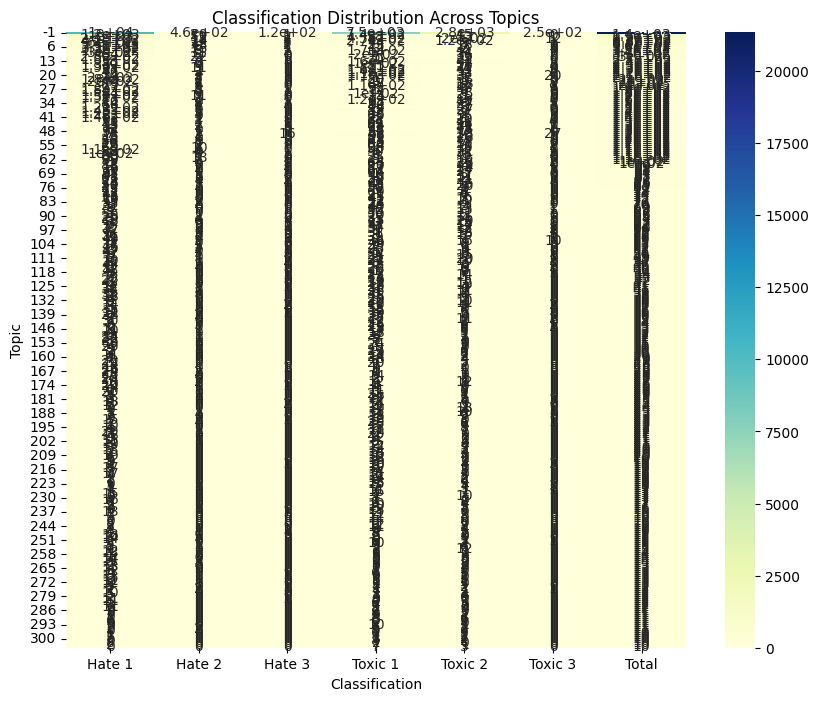

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap of the counts
plt.figure(figsize=(10, 8))
sns.heatmap(topic_classification_counts, annot=True, cmap="YlGnBu")
plt.title("Classification Distribution Across Topics")
plt.ylabel("Topic")
plt.xlabel("Classification")
plt.show()

In [ ]:
topics_to_merge = [[6, 201, 142, 198], []]

In [ ]:
sentence_model_2 = SentenceTransformer(
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
)
# Load the Sentence Transformer model

representation_model = KeyBERTInspired()
vectorizer_model = CountVectorizer(
    ngram_range=(1, 3),
    stop_words=custom_stop_words,
    min_df=3,  # Minimum document frequency for inclusion
)

topic_model_2 = BERTopic(
    representation_model=representation_model,
    embedding_model=sentence_model_2,
    vectorizer_model=vectorizer_model,
)
topics, probs = topic_model_2.fit_transform(text)

from scipy.cluster import hierarchy as sch

#  Hierarchical topics
linkage_function = lambda x: sch.linkage(
    x, "complete", optimal_ordering=True
)  # use either complete or ward
hierarchical_topics_2 = topic_model_2.hierarchical_topics(
    text, linkage_function=linkage_function
)

In [26]:
for topic_num in sorted(topic_model_2.get_topics()):
    words, scores = zip(*topic_model_2.get_topic(topic_num))
    print(f"Topic {topic_num}: {', '.join(words)}")

Topic -1: singaporeans, singaporean, singapore, malay, chinese, china, better, dont, well, theyre
Topic 0: racism, racists, racist, racial, racial harmony, minority race, caucasian, minorities, ethnicity, black people
Topic 1: gender equality, masculinity, think women, men women, sexism, women dont, women men, genders, toxic masculinity, mens
Topic 2: think shes, like shes, shes, bitch, lady, woman, sylvia, girl, thats, racist
Topic 3: hes probably, like hes, hes, hes going, fuck guy, guy, dude, asshole, dick, stupid
Topic 4: lgbtq people, lgbt people, gay people, people gay, gays, lgbt rights, anti lgbt, lgbtq, lgbt, gay sex
Topic 5: siao lang, siao langs, siao, lan jiao, yishun, ah tiong, ang moh, wei, jibai, chibai
Topic 6: chinese taiwanese, west taiwan, taiwanese, chinese singaporeans, taiwan, chinese singaporean, singaporean chinese, chinese singapore, singapore chinese, malaysian chinese
Topic 7: old people, old folks, elderly people, older people, older folks, elderly, elderlie

In [27]:
filtered_df["topic_2"] = topics
topic_classification_counts = (
    filtered_df.groupby(["topic_2", "Classification"]).size().unstack(fill_value=0)
)
topic_classification_counts["Total_2"] = topic_classification_counts.sum(axis=1)

# Print the resulting DataFrame
print(topic_classification_counts)
topic_classification_counts.to_csv("Topic_Classification_Counts_2.csv", index=True)

Classification  Hate 1  Hate 2  Hate 3  Toxic 1  Toxic 2  Toxic 3  Total_2
topic_2                                                                   
-1                9423     425     106     7374     2737      213    20278
 0                1677      71       4       88       51        0     1891
 1                1031      17       1       94       43        0     1186
 2                 272      15       1      583      244       17     1132
 3                 210      15       3      491      246       24      989
...                ...     ...     ...      ...      ...      ...      ...
 295                 5       1       0        4        0        0       10
 296                10       0       0        0        0        0       10
 297                 1       0       0        4        5        0       10
 298                10       0       0        0        0        0       10
 299                10       0       0        0        0        0       10

[301 rows x 7 columns]


In [29]:
tc_df_2 = pd.DataFrame(topic_classification_counts)
tc_df_2["Combined Hate & Toxic 3"] = tc_df_2["Hate 3"] + tc_df_2["Toxic 3"]
sorted_df_2 = tc_df_2.sort_values(by="Combined Hate & Toxic 3", ascending=False)

# Find the top 3 values (this includes handling ties)
top_values_2 = sorted_df_2["Combined Hate & Toxic 3"].nlargest(3)
min_top_value_2 = top_values.min()  # Get the minimum value of the top 3

# Filter the DataFrame to include all topics with values equal to the third highest
top_topics_df_2 = sorted_df_2[sorted_df_2["Combined Hate & Toxic 3"] >= min_top_value_2]

print("Filtered DataFrame for Top 'Combined Hate & Toxic 3' Topics (including ties):")
print(top_topics_df_2)

Filtered DataFrame for Top 'Combined Hate & Toxic 3' Topics (including ties):
Classification  Hate 1  Hate 2  Hate 3  Toxic 1  Toxic 2  Toxic 3  Total_2  \
topic_2                                                                      
-1                9423     425     106     7374     2737      213    20278   
 37                 13       2      17       56       30       18      136   
 3                 210      15       3      491      246       24      989   
 73                 13       5       6       21       20       14       79   
 89                  5       0       5       23       15       14       62   

Classification  Combined Hate & Toxic 3  
topic_2                                  
-1                                  319  
 37                                  35  
 3                                   27  
 73                                  20  
 89                                  19  
